In [5]:
import torch
from torch import optim, save
from torchvision import datasets, transforms
from torchvision.utils import save_image

from matplotlib import pyplot as plt
from IPython import display
from matplotlib.colors import ListedColormap
# import lipmip.utilities as utils
# from lipmip.relu_nets import ReLUNet
# from lipmip.hyperbox import Hyperbox 
# import lipmip.interval_analysis as ia 
# from lipmip.lipMIP import LipMIP
from utils import get_dataloader

import numpy as np

In [4]:
from models.betavae import UTKVAE
from models.old_betavae import VAE

In [6]:
train_loader, test_loader = get_dataloader("utkface")

In [7]:
#vae = UTKVAE({"nz": 32})
vae = VAE({"nc": 3,"ngf": 128,"ndf": 128,"beta": 10,"nz": 32})
vae.cuda()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 256, kernel_size=(4,

In [8]:
vae.load_state_dict(torch.load("saved_models/utkface_beta1_vae.pt"))

<All keys matched successfully>

In [9]:
classes = ['White', 'Black', 'Asian', 'Indian', 'Others']
colours = ListedColormap(['#1988F7', '#D9A464', '#28FC92', '#36EBE5', '#E6407A'])

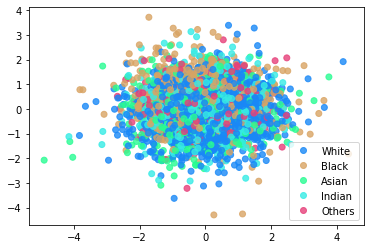

In [10]:
emb_dims = 10
ls = np.array([np.zeros(emb_dims)])
y = np.array([0])
for data, label, _ in train_loader:
    img = data.cuda()
    z, _ = vae.encode(img)
    ls = np.append(ls, z[:, :emb_dims].detach().cpu(), axis=0)
    y = np.append(y, label, axis=0)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    scatter = plt.scatter(ls[:, 0], ls[:, 3], c=y, cmap=colours, alpha=0.8)
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.pause(0.1)
    if ls.shape[0] > 5000:
        break

In [9]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

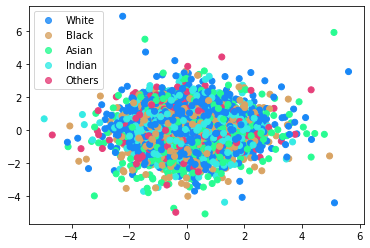

In [10]:
pca = PCA(2)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(ls)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

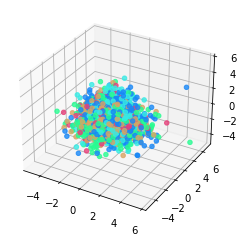

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pca = PCA(3)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(ls)

ax.scatter(Xt[:, 0], Xt[:, 1], Xt[:,2], c=y, cmap=colours, alpha=0.8)

# Save Image for verifying image quality

In [13]:
with torch.no_grad():
    z = torch.randn(64, 32).cuda()
    sample = vae.decode(z).cuda()
    
    save_image(sample.view(64, 3, 64, 64), './samples/utk_sample_' + '.png')

# Load the obfuscator model

In [14]:
from adversarial_training import ARL

In [18]:
arl_config = {'alpha': 0.9,
              'dset': 'utkface', 'obf_in': 10, 'obf_out': 8,
              'lip_reg': False, 'lip_coeff': 0.01,
              'noise_reg': True, 'sigma': 0.01,
              'siamese_reg': True, 'margin': 25, 'lambda': 1.0}
arl = ARL(arl_config)
arl.load_state()

utkface
loaded vae
sucessfully loaded models


# Visualize the embedding space

In [20]:
emb_dims = 10
obf_dims = 8

z = np.array([np.zeros(emb_dims)])
z_tilde = np.array([np.zeros(obf_dims)])
y = np.array([0])

for data, label, _ in train_loader:
    img = data.cuda()
    
    # compute
    emb, _ = vae.encode(img)
    obf = arl.obfuscator(emb)

    # store
    z = np.append(z, emb.detach().cpu(), axis=0)
    z_tilde = np.append(z_tilde, obf.detach().cpu(), axis=0)
    y = np.append(y, label, axis=0)
    if z.shape[0] > 15000:
        break

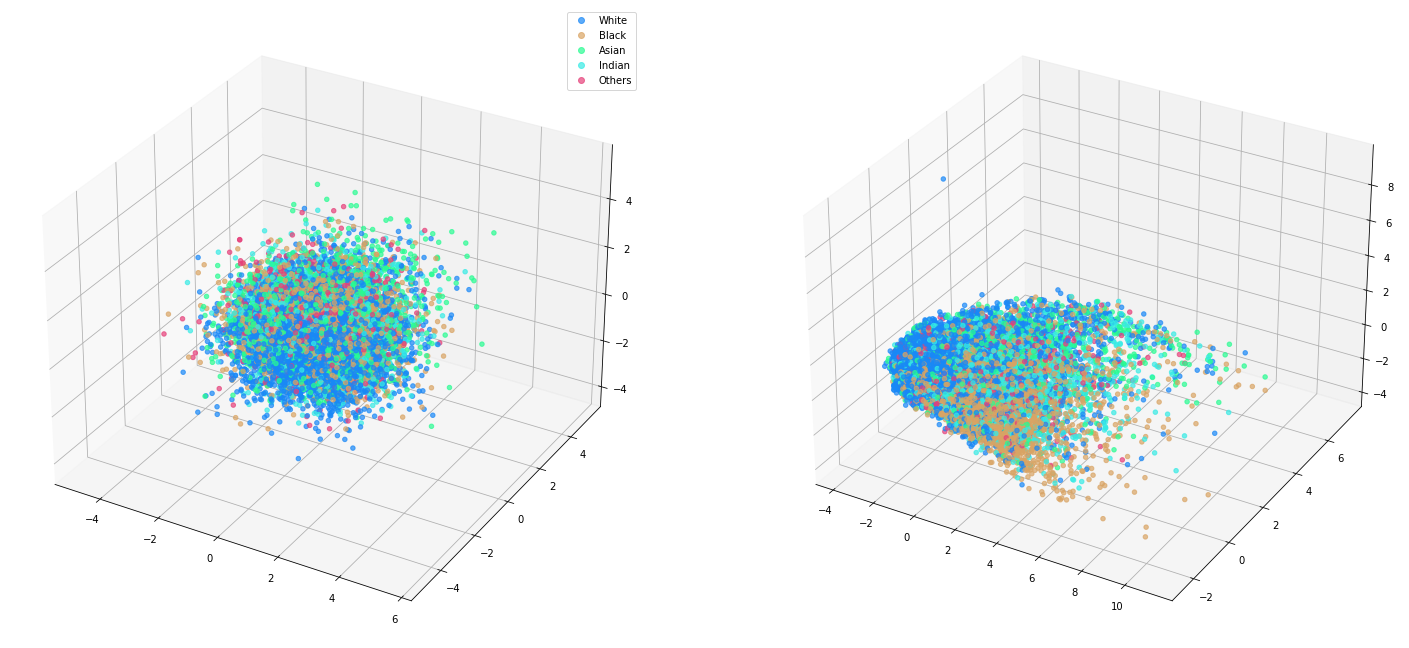

In [21]:
f = plt.figure(figsize=(25, 15))
ax1 = f.add_subplot(1, 2, 1, projection='3d')
ax2 = f.add_subplot(1, 2, 2, projection='3d')

pca = PCA(3)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
z_pca = pipe.fit_transform(z)
z_tilde_pca = pipe.fit_transform(z_tilde)

scatter_emb = ax1.scatter(z_pca[:, 0], z_pca[:, 1], z_pca[:, 2], c=y, cmap=colours, alpha=0.7)
scatter_obf = ax2.scatter(z_tilde_pca[:, 0], z_tilde_pca[:, 1], z_tilde_pca[:, 2], c=y, cmap=colours, alpha=0.7)
#scatter_obf = ax2.scatter(z_tilde[:, 0], z_tilde[:, 1], z_tilde[:, 2], c=y, cmap=colours, alpha=0.7)
ax1.legend(handles=scatter_emb.legend_elements()[0], labels=classes)
# ax2.set_xlim(-3, 3)
# ax2.set_ylim(-3, 3)
# ax2.set_zlim(-3, 3)



# Reconstructing Samples

In [22]:
z, _ = vae.encode(data.cuda())
rec = vae.decode(z).cpu().detach()

In [101]:
index = np.random.randint(data.shape[0])

(-0.5, 63.5, 63.5, -0.5)

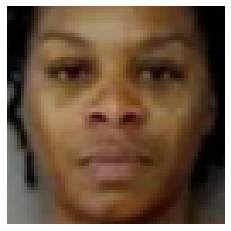

In [102]:
plt.imshow(data[index].permute(1,2,0))
plt.axis("off")

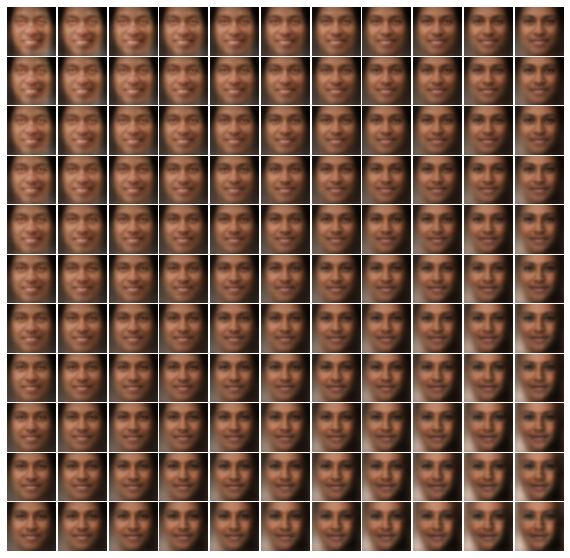

In [103]:
f, ax = plt.subplots(11, 11, figsize=(10, 10))
radius = 1
for i in range(11):
    for j in range(11):
        z_neighbor = z + (i - 5) * radius/5 + (j - 5) * radius/5
        rec_neighbor = vae.decode(z_neighbor).cpu().detach()
        #if i==5 and j==5:
        #    rec_neighbor[rec_neighbor < 0.5] = 0.6
        ax[i][j].imshow(rec_neighbor[index].permute(1,2,0))
        ax[i][j].axis("off")
        ax[i][j].set_aspect('equal')
#ax[0].imshow(data[index][0])
#ax[1].imshow(rec[index][0])
#ax[2].imshow(rec_neighbor[index][0])
plt.subplots_adjust(wspace=0.001, hspace=0.015)

In [37]:
index

64